In [1]:
import pandas as pd 
import numpy as np
import evalml
from evalml import AutoMLSearch

from pandas_profiling import ProfileReport

In [2]:
X = pd.read_csv('data/train.csv', index_col='Id')
X_resulting = pd.read_csv('data/test.csv', index_col='Id')

print(f'X_train shape:\t{X.shape}')
print(f'X_test shape:\t{X_resulting.shape}')

X_train shape:	(1460, 80)
X_test shape:	(1459, 79)


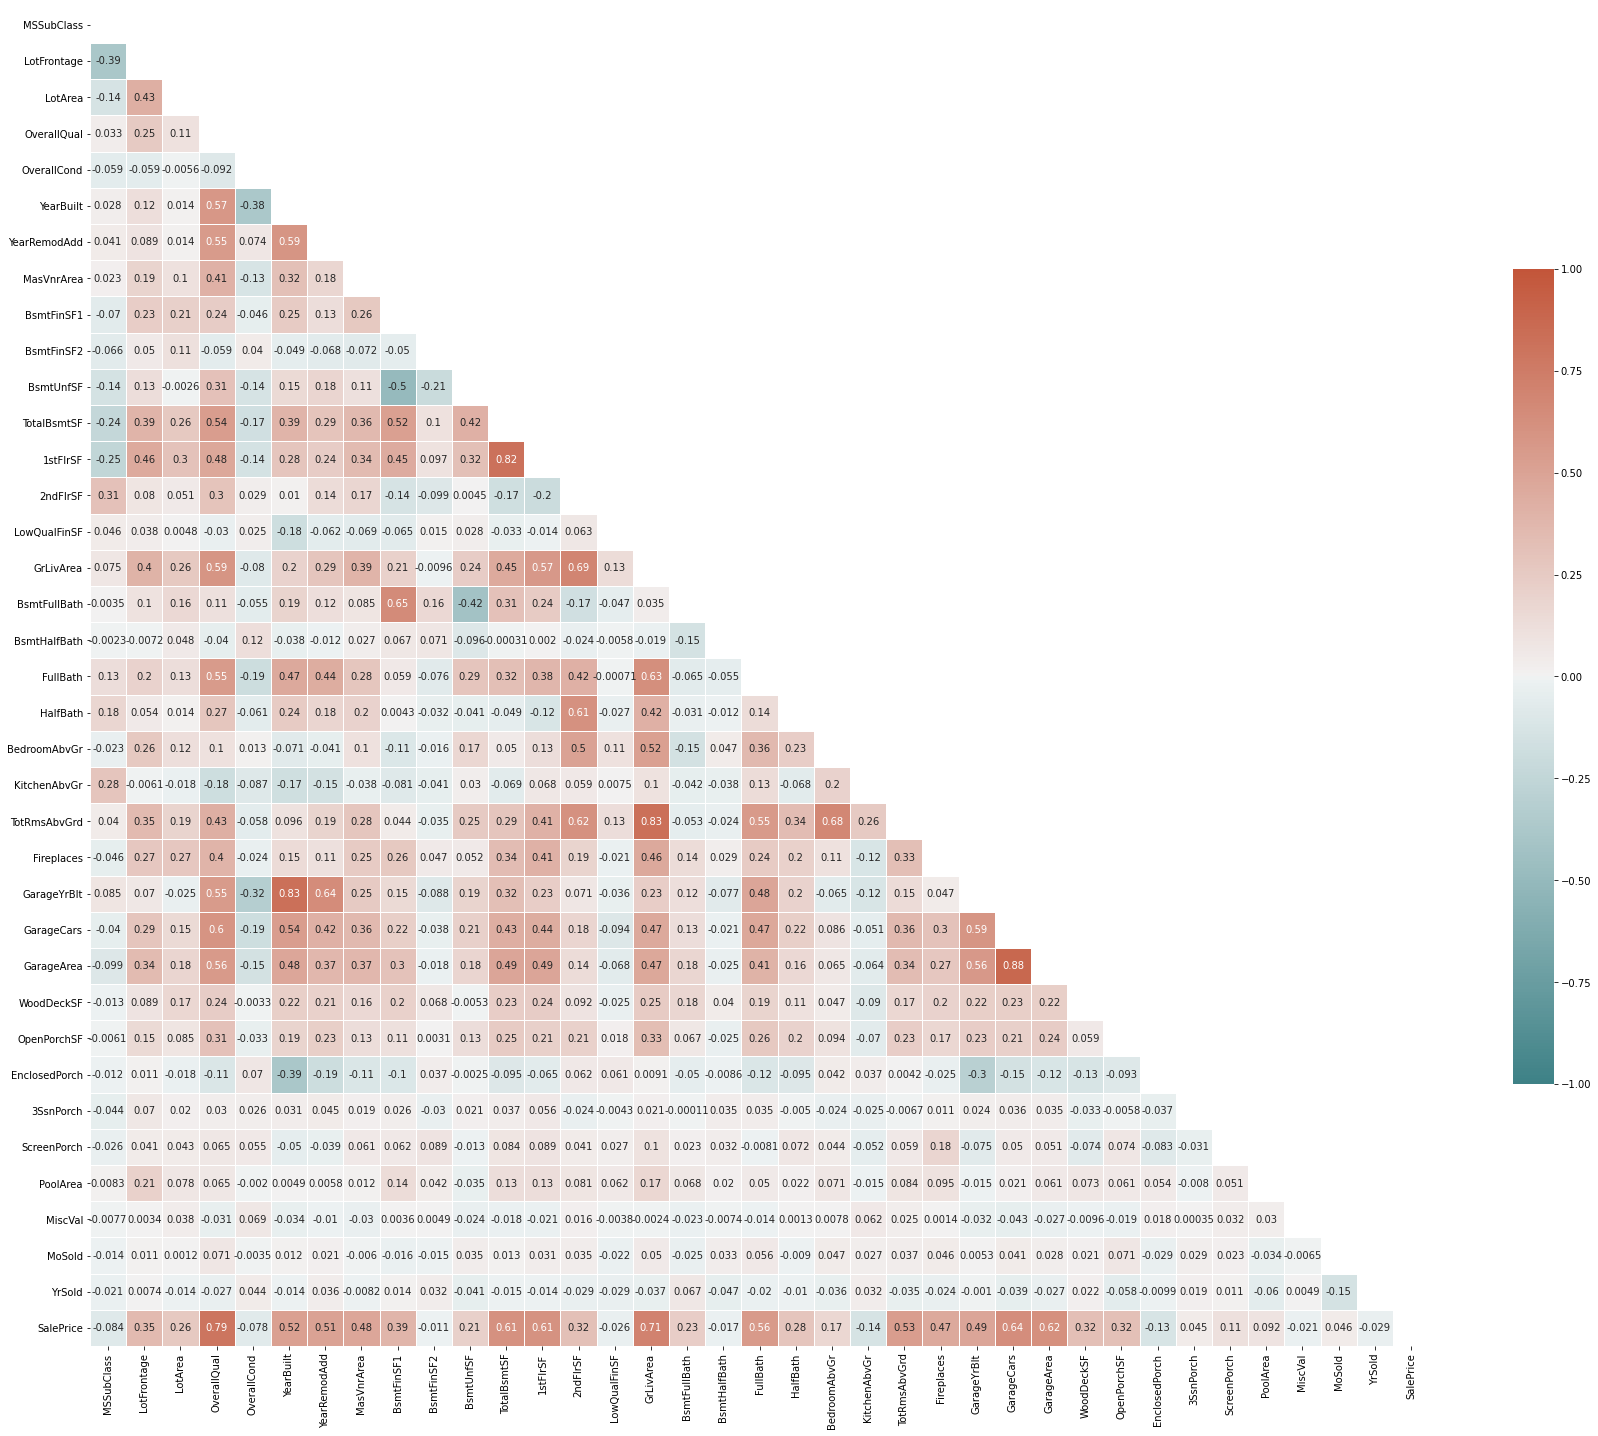

In [168]:
correlation = X.corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(30, 30))

cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5,cbar_kws={'shrink': .5}, annot=True)

# plt.savefig('correlation.jpg')
plt.show()

# Descriptions

That we can from corelation matrix. The most important features are that have the bigest correlation value with `SalePrice`.<br> 
We can single out `OverallQual` and `GrLivArea` which have 0.79 and 0.71 correlation. The lest important features is `BsmftFinSF2`, `BsmftHalfBath` that have -0.011 and -0.017 correlation. <br> We have to highlight features which have hight correlation with other features are `YearBuilt` and `GarageYrBit` have 0.83, and `GrLivArea` and `TotRmsAbvGrd` have 0.83, and `GarageCars` and `GarageArea` have 0.88, and `TotalBsmtSF` and `1stFirSF` have 0.82.

<br>

Using pandasProfiling for showing information about dataset can get some insights. Features that have more then 50% empty values have been droped such as: `Alley`, `MasVnrArea`, `BsmtFinSF2`, `2ndFlrSF`, `LowQualFinSF`(full list you can show into list `columns_drop`). 
Some features have been filled with my view point such as: `LotShape` , `BsmtExposure`, `Utilities` etc. (full list you can see in class `FillNaNMyself`). 
Features that have values orders have been changed categorical values into numerical for example feature `LotShape`: `Reg` = 40, `IR1` = 30, `IR2`=20, `IR3`=10, all that feaures are changed in class `LabelEncodingOwn`. 

Categorical features that have not orders have been transformed using one-hot encoding such as: `MSZoning`, `LandContour`, `LotConfig`(all feaure's names in class `OneHotOwn`).

And if features have not linear dependency that can be demonstrate using `PolynomialFeatures`.
<br>


In [ ]:
prof = ProfileReport(X, title='', explorative=True, progress_bar=True)
prof.to_notebook_iframe()

# prof.to_file('start_analysis.html')

Summarize dataset:   0%|          | 0/94 [00:00<?, ?it/s]

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy = X_copy.drop(self.columns, axis=1)
        return X_copy

class FillNaNMyself(BaseEstimator, TransformerMixin):
    def __init__(self, columns, missin_indecator=True):
        self.columns = columns
        self.missin_indecator=missin_indecator
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        
        if self.missin_indecator:
            for col in self.columns:
                X_copy[col + '_was_missing'] = np.where(X_copy[col].isnull(), 1, 0) 

        X_copy['LotShape'] = X_copy['LotShape'].fillna('IR1')
        X_copy['BsmtExposure'] = X_copy['BsmtExposure'].fillna('NA')
        X_copy['Utilities'] = X_copy['Utilities'].fillna('ELO')
        X_copy['MSZoning'] = X_copy['MSZoning'].fillna('FV')
        X_copy['GarageType'] = X_copy['GarageType'].fillna('NA')
        X_copy['GarageFinish'] = X_copy['GarageFinish'].fillna('NA')
        X_copy['GarageCars'] = X_copy['GarageCars'].fillna(0)
        X_copy['GarageArea'] = X_copy['GarageArea'].fillna(0) 
        X_copy['GarageQual'] = X_copy['GarageQual'].fillna('NA')
        X_copy['GarageCond'] = X_copy['GarageCond'].fillna('NA')
        X_copy['SaleType'] = X_copy['SaleType'].fillna('Oth')

        return X_copy
    
class FillNanAuto(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        columns_with_missing = [col for col in X.columns
                    if np.count_nonzero(X_copy[col].isnull()) > 0]
        
        for col in columns_with_missing:
            X_copy[col] = X_copy[col].fillna(X_copy[col].mode()[0])
        return X_copy
    
class LabelEncodingOwn(BaseEstimator, TransformerMixin):
    ''' 
    label encoding with order for columns:
            Street, , LotShape,Utilities, ExterQual, ExterCond,
            BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1,KitchenQual,
            Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond,
            PavedDrive, 'PoolQC', 'Fence', BsmtFinType2
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        X_copy['Street'] = X_copy['Street'].map({'Grvl': 10, 'Pave':20})
        X_copy['LotShape'] = X_copy['LotShape'].map({'Reg': 40, 'IR1': 30, 'IR2': 20, 'IR3': 10})
        X_copy['Utilities'] = X_copy['Utilities'].map({'AllPub': 40, 'NoSewr': 30, 'NoSeWa': 20, 'ELO': 10})
        X_copy['ExterQual'] = X_copy['ExterQual'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10})
        X_copy['ExterCond'] = X_copy['ExterCond'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10})


        X_copy['BsmtExposure'] = X_copy['BsmtExposure'].map({'Gd':40, 'Av':30, 'Mn':20, 'No':10, 'NA':0})
        X_copy['BsmtQual'] = X_copy['BsmtQual'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10, 'NA':0})
        X_copy['BsmtCond'] = X_copy['BsmtCond'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10, 'NA':0})
        X_copy['BsmtFinType1'] = X_copy['BsmtFinType1'].map({'GLQ':60, 'ALQ':50, 'BLQ':40, 'Rec':30, 'LwQ':20, 'Unf':10, 'NA':0})
        X_copy['BsmtFinType2'] = X_copy['BsmtFinType2'].map({'GLQ':60, 'ALQ':50, 'BLQ':40, 'Rec':30, 'LwQ':20, 'Unf':10, 'NA':0})
        X_copy['HeatingQC'] = X_copy['HeatingQC'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10})

        X_copy['CentralAir'] = X_copy['CentralAir'].map({'N':0, 'Y':1})
        X_copy['KitchenQual'] = X_copy['KitchenQual'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10})
        X_copy['Functional'] = X_copy['Functional'].map({'Sal':10, 'Sev':20, 'Maj2':30, 'Maj1': 40, 'Mod':50, 'Min2': 60, 'Min1':70, 'Typ': 80})
        X_copy['FireplaceQu'] = X_copy['FireplaceQu'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10, 'NA':0})
        X_copy['GarageFinish'] = X_copy['GarageFinish'].map({'NA':0, 'Unf':10, 'RFn':20, 'Fin':30})

        X_copy['GarageQual'] = X_copy['GarageQual'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10, 'NA':0})
        X_copy['GarageCond'] = X_copy['GarageCond'].map({'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10, 'NA':0})
        X_copy['PavedDrive'] = X_copy['PavedDrive'].map({'N':10, 'P':20, 'Y': 30})
        return X_copy

class OneHotOwn(BaseEstimator, TransformerMixin):
    '''
    one-hot-encoding:
        MSZoning, LandContour, LotConfig, LandSlope, Neighborhood, 
        Condition1, Condition2, BldgType ,HouseStyle, RoofStyle, 
        RoofMatl, Exterior1st,Exterior2nd, MasVnrType, Foundation,
        Heating,Electrical, GarageType, 'MiscFeature', SaleType, SaleCondition
    '''
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        dummies = pd.get_dummies(X_copy[self.columns],drop_first=True)

        X_copy = X_copy.drop(self.columns, axis=1)
        final = pd.concat([X_copy, dummies], axis=1)
        
        return final

class PolynomialFeaturesPreparing(BaseEstimator, TransformerMixin):
    def __init__(self, columns, degree=2):
        self.columns = columns
        self.degree = degree
        
    def fit(self, X, y=None):
        X_copy = X.copy()
        
        X_for_transform = X_copy[self.columns]
        self.poly = PolynomialFeatures(degree=self.degree)
        self.poly.fit(X_for_transform)
        self.feature_names = self.poly.get_feature_names(input_features=self.columns)
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_for_transform = X_copy[self.columns]
        X_transformed = self.poly.transform(X_for_transform)
        X_transformed = pd.DataFrame(X_transformed, columns=self.feature_names, index=X_for_transform.index)
        
        X_resulting = X_copy.drop(self.columns, axis=1)
        
        X_resulting = pd.concat([X_resulting, X_transformed], axis=1)
        
        return X_resulting

In [4]:
columns_with_missing = [col for col in X.columns
                    if np.count_nonzero(X[col].isnull()) > 0]

columns_drop = ['Alley', 'MasVnrArea', 'BsmtFinSF2', '2ndFlrSF', 
                'LowQualFinSF', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch',
               'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal', 'Fence']

columns_filled = ['Utilities', 'MSZoning', 'GarageType', 'GarageFinish', 
                      'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType', 
                     'LotShape', 'BsmtExposure']

columns_with_missing = np.setdiff1d(columns_with_missing, columns_drop)
columnss_with_missing_filled = np.setdiff1d(np.setdiff1d(columns_with_missing, columns_filled), columns_drop)

columns_one_hot = ['MSZoning', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 
        'Condition1', 'Condition2', 'BldgType' ,'HouseStyle', 'RoofStyle', 
        'RoofMatl', 'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation',
        'Heating','Electrical', 'GarageType', 'SaleType', 'SaleCondition']

columns_polynomial = np.setdiff1d(columns_filled + ['MSSubClass', 'LotFrontage', 'LotArea',
                                      'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterCond',
                                      'BsmtFinType2', 'HeatingQC', '1stFlrSF', 'GrLivArea',
                                      'BedroomAbvGr', 'HalfBath','FullBath', 'TotRmsAbvGrd', 'KitchenQual',
                                      'TotRmsAbvGrd', 'MoSold'], columns_one_hot)

prepared_pipeline = Pipeline([('DropColumns', DropColumns(columns=columns_drop)),
                             ('FillNaNMyself', FillNaNMyself(columns=columns_filled)),
                             ('FillNanAuto', FillNanAuto(columns=columns_with_missing)),
                             ('LabelEncodingOwn', LabelEncodingOwn()),
                             ('OneHotOwn', OneHotOwn(columns=columns_one_hot)),
                             ('PolynomialFeaturesPreparing', PolynomialFeaturesPreparing(columns=columns_polynomial, degree=2))
                             ])

X_full = pd.concat([X, X_resulting], axis=0)
X_full_prepared = prepared_pipeline.fit_transform(X_full)

X_prepared = X_full_prepared.head(X.shape[0])
X_resulting_prepared = X_full_prepared.tail(X_resulting.shape[0]).drop(['SalePrice'], axis=1)
# X_prepared = prepared_pipeline.fit_transform(X)
# X_resulting_prepared = prepared_pipeline.transform(X_resulting)
print(f'X_prepared shape:\t{X_prepared.shape}')
print(f'X_resulting_prepared shape:\t{X_resulting_prepared.shape}')

# X_submit_prepared = prepared_pipeline.transform(X_resulting)

X_prepared shape:	(1460, 523)
X_resulting_prepared shape:	(1459, 522)


In [ ]:
prof = ProfileReport(X_prepared, title='', explorative=True, progress_bar=True)
prof.to_notebook_iframe()

prof.to_file('prepared_analysis.html')

Summarize dataset:   0%|          | 0/211 [00:00<?, ?it/s]

# Spliting Train and Test set

In [47]:
from sklearn.model_selection import train_test_split

# After preparation 
X_new = X_prepared.drop(['SalePrice'], axis=1).copy()
y = X_prepared['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=10)

# Let's see what show for us autoML after preparation our dataset

In [122]:
automl = AutoMLSearch(X_train=X_train,
                     y_train=y_train,
                      problem_type='regression',
                      objective='r2',
                      additional_objectives=['mae', 'mse','expvariance']
                     )
automl.search()

Using default limit of max_batches=1.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for R2. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: decision_tree, lightgbm, catboost, random_forest, linear_model, extra_trees, xgboost



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean R2: -0.003
High coefficient of variation (cv >= 0.2) within cross validation scores. Mean Baseline Regression Pipeline may not perform as estimated on unseen data.
Batch 1: (2/9) Decision Tree Regressor w/ Imputer       Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean R2: 0.753
Batch 1: (3/9) Extra Trees Regressor w/ Imputer         Elapsed:00:11
	Starting cross validation
	Finished cross validation - mean R2: 0.841
Batch 1: (4/9) XGBoost Regressor w/ Imputer             Elapsed:00:22
	Starting cross validation
	Finished cross validation - mean R2: 0.843
Batch 1: (5/9) CatBoost Regressor w/ Imputer            Elapsed:00:34
	Starting cross validation
	Finished cross validation - mean R2: 0.294
Batch 1: (6/9) Random Forest Regressor w/ Imputer       Elapsed:00:44
	Starting cross validation
	Finished cross validation - mean R2: 0.846


/home/eduard/anaconda3/envs/ml_coursera/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 207102077672.49384, tolerance: 546051804.3659564

/home/eduard/anaconda3/envs/ml_coursera/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 272389108623.45483, tolerance: 550435741.5936424

/home/eduard/anaconda3/envs/ml_coursera/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 253625787368.451, tolerance: 549482268.9086723



	Finished cross validation - mean R2: 0.863

Search finished after 01:33            
Best pipeline: Elastic Net Regressor w/ Imputer + Standard Scaler
Best pipeline R2: 0.863183


/home/eduard/anaconda3/envs/ml_coursera/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 394163305065.1835, tolerance: 823298018.9794391



In [123]:
automl.rankings

,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,8,Elastic Net Regressor w/ Imputer + Standard Sc...,0.863183,0.791592,2.529653e+04,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,5,Random Forest Regressor w/ Imputer,0.845561,0.827641,2.478217e+04,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,3,XGBoost Regressor w/ Imputer,0.842532,0.775831,2.469372e+04,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,2,Extra Trees Regressor w/ Imputer,0.840612,0.817937,2.463768e+04,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,6,LightGBM Regressor w/ Imputer,0.837294,0.830939,2.454084e+04,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,1,Decision Tree Regressor w/ Imputer,0.753317,0.730251,2.208953e+04,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,4,CatBoost Regressor w/ Imputer,0.293954,0.301749,8.680595e+03,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,0,Mean Baseline Regression Pipeline,-0.003426,-0.005322,0.000000e+00,True,{'Baseline Regressor': {'strategy': 'mean'}}
8,7,Linear Regressor w/ Imputer + Standard Scaler,-90.315476,0.317031,-2.636233e+06,True,{'Imputer': {'categorical_impute_strategy': 'm...


# Training our models

In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [12]:
from sklearn.metrics import r2_score, explained_variance_score

def define_metrics(model, X_train_, X_test_, y_train, y_test, name):
    
    pred_train_ = list(model.predict(X_train_))
    pred_test_ = list(model.predict(X_test_))
    y_train_ = list(y_train)
    y_test_ = list(y_test)
    


    metric_train = pd.DataFrame()
    metric_train['name'] = [name + '_train']
    metric_train['R2'] = [r2_score(y_train, pred_train_)]
    metric_train['RSS'] = np.sum((y_train - pred_train_) ** 2)
    metric_train['MAPE'] = [np.mean(np.abs((y_train - pred_train_) / y_train)) * 100]
    metric_train['RMSE'] = [np.sqrt(np.mean((y_train - pred_train_) ** 2))]

    metric_train['ex_var'] = [explained_variance_score(y_train, pred_train_)]

    metric_test = pd.DataFrame()
    metric_test['name'] = [name + '_test']
    metric_test['R2'] = [r2_score(y_test, pred_test_)]
    metric_test['RSS'] = np.sum((y_test - pred_test_) ** 2)

    metric_test['MAPE'] = [np.mean(np.abs((y_test - pred_test_) / y_test)) * 100]
    metric_test['RMSE'] = [np.sqrt(np.mean((y_test - pred_test_) ** 2))]
    metric_test['ex_var'] = [explained_variance_score(y_test, pred_test_)]

    return metric_train.append(metric_test)

## ElasticNet fitting

In [91]:
%%time
elas = ElasticNet(normalize=True, random_state=13)
grid = {
    'l1_ratio': np.linspace(1e-4, 1, 10),
    'alpha': np.linspace(1e-5, 1, 10),
    
}



n_splits = 10
clf4 = GridSearchCV(elas, grid, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=n_splits, shuffle=True),
                  scoring='r2',
                  verbose=2, refit=True)
clf4.fit(X_train, y_train)

print()
print(clf4.best_estimator_)

name='ElasticNet'
model = clf4
score_model = define_metrics(model, X_train, X_test, y_train, y_test, name)
score_model

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


The least populated class in y has only 1 members, which is less than n_splits=10.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 382 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 867 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 977 out of 1000 | elapsed:   30.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.6s finished



ElasticNet(alpha=1e-05, l1_ratio=0.0001, normalize=True, random_state=13)
CPU times: user 5.09 s, sys: 1.77 s, total: 6.86 s
Wall time: 33.1 s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 274369945858.46277, tolerance: 841787639.9913958


,name,R2,RSS,MAPE,RMSE,ex_var
0,ElasticNet_train,0.944989,4.630788e+11,7.479807,18772.830033,0.944989
0,ElasticNet_test,0.908875,7.196106e+10,9.146698,22200.990918,0.909148


In [81]:
clf4.best_estimator_

ElasticNet(alpha=1e-05, l1_ratio=0.4445, normalize=True, random_state=13)

# Random Forest Fitting

In [53]:
%%time
rfr = RandomForestRegressor()
grid = {}

grid = {
    'n_estimators': [1000, 1500, 2000],
    'criterion': ['mse'],
    'max_features': ['sqrt'],
#     'min_samples_split': [1,5,10],
#     'min_samples_leaf': []
    'max_depth': [5,6],
    'bootstrap':[True],
#     'ccp_alpha': [0.1,0.2,0.3]
}

n_splits = 5
clf3 = GridSearchCV(rfr, grid, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=10, shuffle=True),
                  scoring='r2',
                  verbose=2, refit=True)
clf3.fit(X_train, y_train)

print()
print(clf3.best_params_)
print(clf3.best_estimator_)

name='RandomForestRegressor'
model = clf3
score_model = define_metrics(model, X_train, X_test, y_train, y_test, name)
score_model

Fitting 10 folds for each of 6 candidates, totalling 60 fits


The least populated class in y has only 1 members, which is less than n_splits=10.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   43.8s finished



{'bootstrap': True, 'criterion': 'mse', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 2000}
CPU times: user 7.24 s, sys: 196 µs, total: 7.24 s
Wall time: 50.8 s


,name,R2,RSS,MAPE,RMSE,ex_var
0,RandomForestRegressor_train,0.931067,5.802671e+11,9.213111,21014.365615,0.931067
0,RandomForestRegressor_test,0.855172,1.143702e+11,10.662364,27988.524274,0.856908


In [78]:
clf3.best_estimator_

RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=2000)

# XGBoost

In [60]:
%%time
xgbr = XGBRegressor(gpu_id=0)
grid = {
    'objective': ['reg:squarederror'],
    'n_estimators':[100],
    'max_depth' :[4],
#     'reg_lambda': np.linspace(1e-3, 1000, 100)
#     'gamma' : [0,1e-2,1e-1,0.2]
}

# dtrain = xgb.DMatrix(X_train)
# dtest = xgb.DMatrix(X_test)


n_splits = 5
clf5 = GridSearchCV(xgbr, grid, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=n_splits, shuffle=True),
                  scoring='r2',
                  verbose=2, refit=True)
clf5.fit(X_train, y_train)

print()
print(clf5.best_params_)
print(clf5.best_estimator_)

name='XGBRegressor'
model = clf5
score_model = define_metrics(model, X_train, X_test, y_train, y_test, name)
score_model

Fitting 5 folds for each of 4 candidates, totalling 20 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.1s finished



{'gamma': 0, 'max_depth': 4, 'n_estimators': 100, 'objective': 'reg:squarederror'}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
CPU times: user 5.67 s, sys: 61.2 ms, total: 5.74 s
Wall time: 6.81 s


,name,R2,RSS,MAPE,RMSE,ex_var
0,XGBRegressor_train,0.997924,1.747348e+10,1.795352,3646.632708,0.997924
0,XGBRegressor_test,0.874688,9.895793e+10,9.116116,26034.477517,0.875856


# Gradient Boosting Regressor

In [54]:
%%time 
gbr = GradientBoostingRegressor()

grid = {
    'loss': ['lad', 'quantile'],
    'criterion': ['mse'],
    'n_estimators':[50, 80, 100],
        'max_features': ['sqrt', 'auto'],

#     'max_depth' :[4],
}

n_splits = 5
clf6 = GridSearchCV(gbr, grid, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=n_splits, shuffle=True),
                  scoring='r2',
                  verbose=2, refit=True)
clf6.fit(X_train, y_train)

print()
print(clf6.best_params_)
print(clf6.best_estimator_)

name='GradientBoostingRegressor'
model = clf6
score_model = define_metrics(model, X_train, X_test, y_train, y_test, name)
score_model

Fitting 5 folds for each of 12 candidates, totalling 60 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.9s finished



GradientBoostingRegressor(criterion='mse', loss='lad', max_features='auto')
CPU times: user 5 s, sys: 16.4 ms, total: 5.02 s
Wall time: 19.7 s


,name,R2,RSS,MAPE,RMSE,ex_var
0,GradientBoostingRegressor_train,0.924931,6.319217e+11,6.118202,21929.763074,0.925414
0,GradientBoostingRegressor_test,0.887500,8.884103e+10,8.404211,24667.797525,0.889824


In [85]:
clf6.best_estimator_

GradientBoostingRegressor(criterion='mse', loss='lad', max_features='auto')

# Let's show the most valuable features for our trained models

In [86]:
elasr = ElasticNet(alpha=1e-05, l1_ratio=0.4445, normalize=True, random_state=13)
rfr  = RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=2000)
xgbr = XGBRegressor(max_depth=4, n_estimators=100, objective='reg:squarederror', reg_lambda=30.304000000000006)
gbr = GradientBoostingRegressor(criterion='mse', loss='lad', max_features='auto')

elasr.fit(X_train, y_train)
rfr.fit(X_train, y_train)
xgbr.fit(X_train, y_train)
gbr.fit(X_train, y_train)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 253364801787.73825, tolerance: 841787639.9913958


GradientBoostingRegressor(criterion='mse', loss='lad', max_features='auto')

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

features = X_train.columns

def barplot(data, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=data['feature'], y=data['value'])
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

def get_feature_importances(importances, features, count_feaures=50, name='model'):
    feat_imp = dict((value, name) for value, name in zip(features, importances)) 

    feat_imp = sorted(feat_imp.items(), key=lambda x: np.abs(x[1]), reverse=True)
    feat_imp = pd.DataFrame(feat_imp, columns=['feature', 'value'])
    
    barplot(feat_imp[:count_feaures], title=name)
    
    return feat_imp

## Features importances for `ElasticNet` model

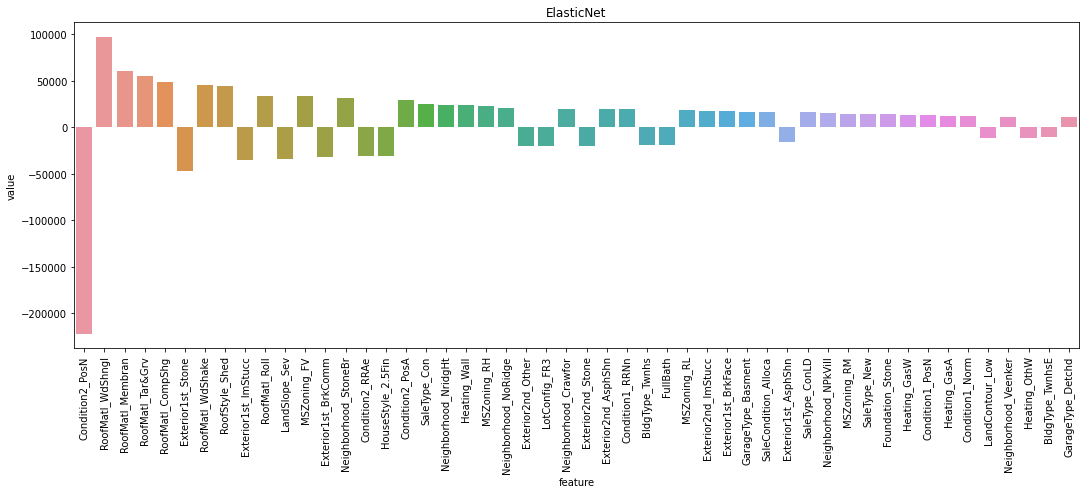

,feature,value
0,Condition2_PosN,-221696.479122
1,RoofMatl_WdShngl,96941.285985
2,RoofMatl_Membran,60434.787657
3,RoofMatl_Tar&Grv,55144.992756
4,RoofMatl_CompShg,48413.440240
5,Exterior1st_Stone,-47134.917696
6,RoofMatl_WdShake,45183.601579
7,RoofStyle_Shed,44652.811451
8,Exterior1st_ImStucc,-34768.015859
9,RoofMatl_Roll,33878.208067


In [111]:
importances = elasr.coef_

feat_imp = get_feature_importances(importances, features, name='ElasticNet')
feat_imp[:50]

## Features importances for `RandomForestRegressor` model

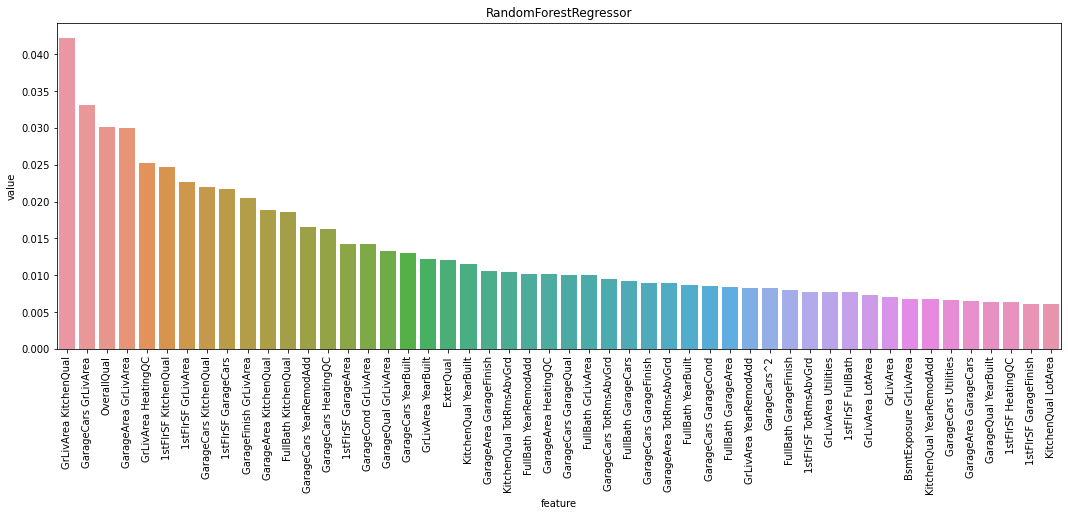

,feature,value
0,GrLivArea KitchenQual,0.042184
1,GarageCars GrLivArea,0.033135
2,OverallQual,0.030092
3,GarageArea GrLivArea,0.029999
4,GrLivArea HeatingQC,0.025244
5,1stFlrSF KitchenQual,0.024743
6,1stFlrSF GrLivArea,0.022644
7,GarageCars KitchenQual,0.021960
8,1stFlrSF GarageCars,0.021682
9,GarageFinish GrLivArea,0.020455


In [115]:
importances = rfr.feature_importances_

feat_imp = get_feature_importances(importances, features, name='RandomForestRegressor')
feat_imp[:50]

## Features importances for `XGBRegressor` model

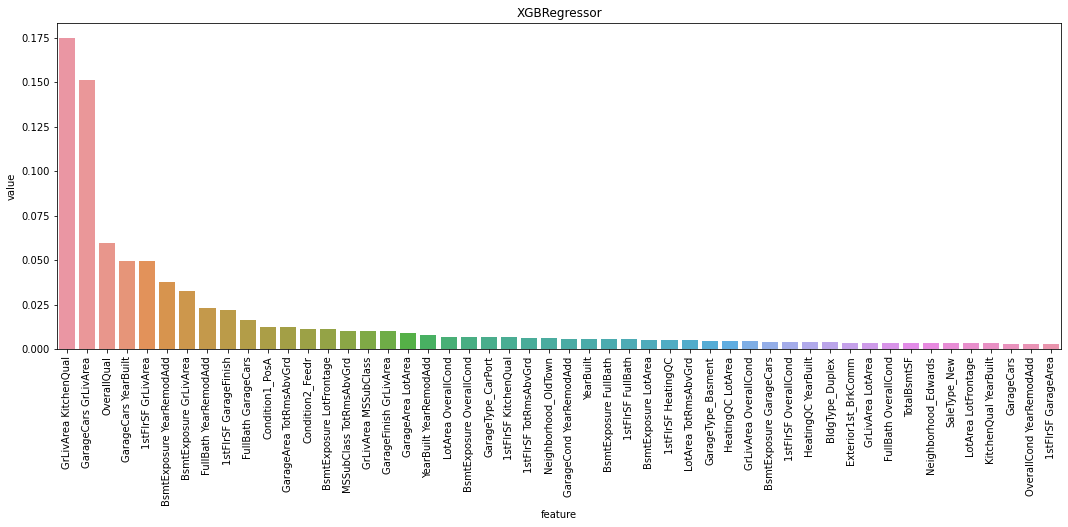

,feature,value
0,GrLivArea KitchenQual,0.174576
1,GarageCars GrLivArea,0.151394
2,OverallQual,0.059662
3,GarageCars YearBuilt,0.049500
4,1stFlrSF GrLivArea,0.049224
5,BsmtExposure YearRemodAdd,0.037530
6,BsmtExposure GrLivArea,0.032878
7,FullBath YearRemodAdd,0.022922
8,1stFlrSF GarageFinish,0.022143
9,FullBath GarageCars,0.016523


In [117]:
importances = xgbr.feature_importances_

feat_imp = get_feature_importances(importances, features, name='XGBRegressor')
feat_imp[:50]

## Features importances for `GradientBoostingRegressor` model

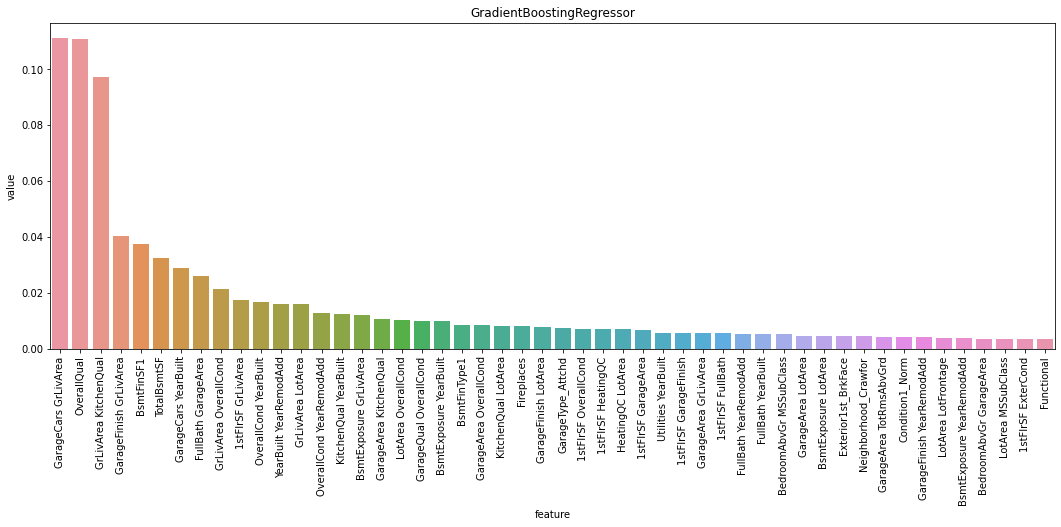

,feature,value
0,GarageCars GrLivArea,0.111004
1,OverallQual,0.110663
2,GrLivArea KitchenQual,0.097333
3,GarageFinish GrLivArea,0.040369
4,BsmtFinSF1,0.037501
5,TotalBsmtSF,0.032626
6,GarageCars YearBuilt,0.029059
7,FullBath GarageArea,0.026032
8,GrLivArea OverallCond,0.021335
9,1stFlrSF GrLivArea,0.017353


In [118]:
importances = gbr.feature_importances_

feat_imp = get_feature_importances(importances, features, name='GradientBoostingRegressor')
feat_imp[:50]

# Ensemble for models 

In [65]:
def get_models():
    models = list()
    models.append(('ElasticNet', ElasticNet(alpha=1e-05, l1_ratio=0.4445, normalize=True, random_state=13)))
    models.append(('RandomForestRegressor', RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=2000)))
    models.append(('XGBRegressor', XGBRegressor(max_depth=4, n_estimators=100, objective='reg:squarederror', reg_lambda=30.304000000000006)))
    models.append(('GradientBoostingRegressor', GradientBoostingRegressor(criterion='mse', loss='lad', max_features='auto')))
    
    return models

In [66]:
%%time

from sklearn.ensemble import VotingRegressor

models = get_models()

ensemble = VotingRegressor(estimators=models,
                                      n_jobs=-1,
                          verbose=True).fit(X_train, y_train)

name='ensemble'
model = ensemble
score_model = define_metrics(model, X_train, X_test, y_train, y_test, name)
score_model

CPU times: user 1.01 s, sys: 1.64 s, total: 2.65 s
Wall time: 7.64 s


,name,R2,RSS,MAPE,RMSE,ex_var
0,ensemble_train,0.966094,2.854196e+11,5.747677,14738.193337,0.966120
0,ensemble_test,0.903257,7.639733e+10,7.973326,22875.081817,0.905349


# Stacking models

## Train for checking accuracy

In [67]:
%%time
from sklearn.ensemble import StackingRegressor

models = get_models()
stackModel = StackingRegressor(estimators=models)
stackModel.fit(X_train, y_train)

name='StackingRegressor'
model = stackModel
score_model = define_metrics(model, X_train, X_test, y_train, y_test, name)
score_model

Objective did not converge. You might want to increase the number of iterations. Duality gap: 253364801787.73825, tolerance: 841787639.9913958
Objective did not converge. You might want to increase the number of iterations. Duality gap: 185626629986.56845, tolerance: 671934674.4957632
Objective did not converge. You might want to increase the number of iterations. Duality gap: 176955265839.9006, tolerance: 629265592.8857756
Objective did not converge. You might want to increase the number of iterations. Duality gap: 188721367838.04523, tolerance: 694572666.1685402
Objective did not converge. You might want to increase the number of iterations. Duality gap: 150857616236.45862, tolerance: 701563117.0803626
Objective did not converge. You might want to increase the number of iterations. Duality gap: 153145527985.97232, tolerance: 669464613.9188619


CPU times: user 1min 29s, sys: 9.91 s, total: 1min 38s
Wall time: 1min 2s


,name,R2,RSS,MAPE,RMSE,ex_var
0,StackingRegressor_train,0.973201,2.255904e+11,5.006471,13102.755137,0.973203
0,StackingRegressor_test,0.912476,6.911740e+10,7.616349,21757.913899,0.915694


## We have gotten better result and can train on full dataset, and make predictions

In [50]:
%%time
stackModel = StackingRegressor(estimators=models)
stackModel.fit(X_new, y)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 283244586981.56793, tolerance: 920791133.4609975
Objective did not converge. You might want to increase the number of iterations. Duality gap: 219423204395.33127, tolerance: 759214014.2531197
Objective did not converge. You might want to increase the number of iterations. Duality gap: 173458293025.91998, tolerance: 728773513.025937
Objective did not converge. You might want to increase the number of iterations. Duality gap: 175564633000.7964, tolerance: 699031751.5199751
Objective did not converge. You might want to increase the number of iterations. Duality gap: 221247949869.95483, tolerance: 770619031.1834062
Objective did not converge. You might want to increase the number of iterations. Duality gap: 182511497128.5024, tolerance: 724930391.3116124


CPU times: user 1min 36s, sys: 8.1 s, total: 1min 45s
Wall time: 1min 8s


StackingRegressor(estimators=[('ElasticNet',
                               ElasticNet(alpha=1e-05, l1_ratio=0.4445,
                                          normalize=True, random_state=13)),
                              ('RandomForestRegressor',
                               RandomForestRegressor(max_depth=6,
                                                     max_features='sqrt',
                                                     n_estimators=2000)),
                              ('XGBRegressor',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_e

In [52]:
predictions = stackModel.predict(X_resulting_prepared)

submition = pd.DataFrame()
submition['Id'] = X_resulting_prepared.index.to_list()
submition['SalePrice'] = predictions

submition.to_csv('prediction.csv', index=False)